# Solvers comparison

This notebook aims at providing a template to perform comparisons in computational time between different solvers.
To use this notebook, the user is expected to run the following procedure:
1. Setup the config.yaml file for the simulation
2. For every solver 'solver' under consideration:
   1. Setup the solver option in the config.yaml file 
   2. Run the workflow with snakemake
   3. Rename the folder benchmarks/solve_network into benchmarks/solve_network_{solver}
   4. Rename the folder results into results_{solver}
3. Modify the list 'solver_to_compare' below to specify the solvers to consider
4. Run the notebook

## Change the current directory to the main package folder

In [1]:
# Specify the current directory
import sys

sys.path.append("../")  # to import helpers

from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-africa")

This is the repository path:  /data/davidef/git_pma/pypsa-africa
Had to go 1 folder(s) up.


## Specify the solvers to compare

In [2]:
# list of solvers to compare
solvers_to_compare = ["gurobi", "highs"]

# list of configurations to compare and their description
configs_to_compare = {
    "elec_s_10_ec_lcopt_Co2L-1H": 10,  # "10-cluster",
    "elec_s_20_ec_lcopt_Co2L-1H": 20,  # "20-cluster",
    "elec_s_54_ec_lcopt_Co2L-1H": 54,  # "54-cluster",
}

## Import packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pypsa

## Compare computational resources
### Preload input data

In [4]:
comp_time_by_solver = []

for solver in solvers_to_compare:
    for conf_name, conf_desc in configs_to_compare.items():
        tempdata = pd.read_csv(
            "benchmarks/solve_network_" + solver + "/" + conf_name, delimiter="\t"
        )
        comp_time_by_solver.append(
            [solver, conf_desc, conf_name] + list(tempdata.values[0])
        )

comp_time_by_solver = pd.DataFrame(
    comp_time_by_solver,
    columns=[
        "solver",
        "config",
        "filename",
        "s",
        "h:m:s",
        "max_rss",
        "max_vms",
        "max_uss",
        "max_pss",
        "io_in",
        "io_out",
        "mean_load",
        "cpu_time",
    ],
)

### Total computational time

Text(0.5, 0, 'Number of clusters')

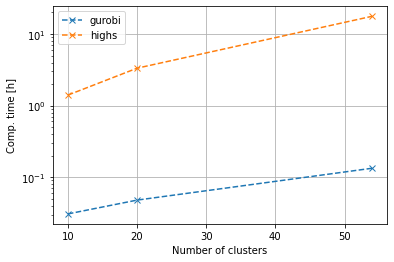

In [5]:
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[comp_time_by_solver["solver"] == solver, "s"] / 3600,
        linestyle="dashed",
        marker="x",
        label=solver,
    )
plt.ylabel("Comp. time [h]")
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Number of clusters")

### Total workload

Text(0.5, 0, 'Number of clusters')

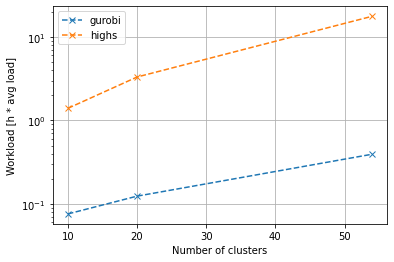

In [6]:
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[
            comp_time_by_solver["solver"] == solver, ["s", "mean_load"]
        ].product(axis=1)
        / 3600
        / 100,
        label=solver,
        linestyle="dashed",
        marker="x",
    )
plt.ylabel("Workload [h * avg load]")
plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Number of clusters")

### Total workload & computational time

Text(0.5, 0, 'Number of clusters')

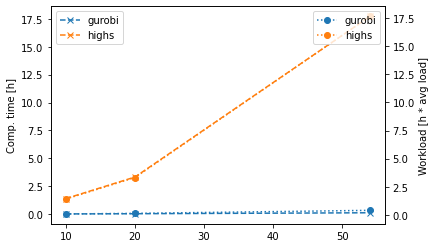

In [7]:
# Plot computational time
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[comp_time_by_solver["solver"] == solver, "s"] / 3600,
        linestyle="dashed",
        marker="x",
        label=solver,
    )

# plt.yscale("log")
plt.ylabel("Comp. time [h]")
plt.legend()
# Plot workload on right y axis
ax2 = plt.twinx()
for solver in solvers_to_compare:
    ax2.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[
            comp_time_by_solver["solver"] == solver, ["s", "mean_load"]
        ].product(axis=1)
        / 3600
        / 100,
        label=solver,
        linestyle="dotted",
        marker="o",
    )
ax2.legend(loc=1)
# plt.yscale("log")
plt.ylabel("Workload [h * avg load]")
plt.xlabel("Number of clusters")

### Maximum virtual memory

Text(0.5, 0, 'Number of clusters')

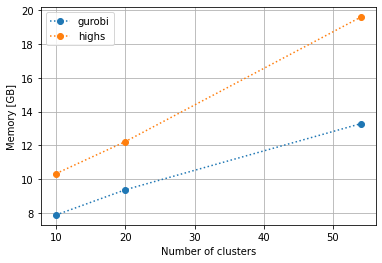

In [8]:
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[comp_time_by_solver["solver"] == solver, "max_vms"]
        / 1000,
        label=solver,
        linestyle="dotted",
        marker="o",
    )
plt.ylabel("Memory [GB]")
# plt.yscale("log")
plt.grid()
plt.legend()
plt.xlabel("Number of clusters")

### Total workload & memory

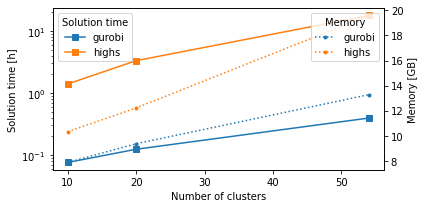

In [9]:
plt.figure(figsize=(6, 3))

# Plot workload
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[
            comp_time_by_solver["solver"] == solver, ["s", "mean_load"]
        ].product(axis=1)
        / 3600
        / 100,
        label=solver,
        linestyle="solid",
        marker="s",
    )

plt.yscale("log")
plt.ylabel("Solution time [h]")
plt.xlabel("Number of clusters")
plt.legend(title="Solution time")
# Plot workload on right y axis
ax2 = plt.twinx()
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_time_by_solver.loc[comp_time_by_solver["solver"] == solver, "max_vms"]
        / 1000,
        label=solver,
        linestyle="dotted",
        marker=".",
    )
plt.ylabel("Memory [GB]")
ax2.legend(title="Memory", loc=1)
# plt.yscale('log')
#
plt.tight_layout()
plt.savefig("solver_comparison.pdf")

## Comparison of the solutions
### Preload results

In [10]:
comp_results_by_solver = []

for solver in solvers_to_compare:
    for conf_name, conf_desc in configs_to_compare.items():
        n = pypsa.Network("results_" + solver + "/networks/" + conf_name + ".nc")
        comp_results_by_solver.append(
            [solver, conf_desc, conf_name] + [n.objective, n.generators.p_nom_opt.sum()]
        )

comp_results_by_solver = pd.DataFrame(
    comp_results_by_solver,
    columns=["solver", "config", "filename", "objective", "p_nom_opt"],
)

INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_20_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_54_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_10_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_20_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_54_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


### Plot of objective function

Text(0.5, 0, 'Number of clusters')

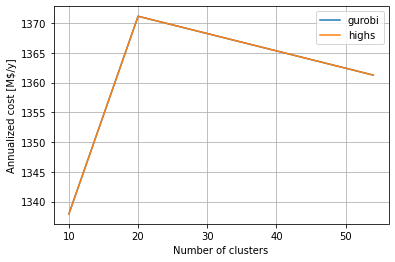

In [11]:
for solver in solvers_to_compare:
    plt.plot(
        configs_to_compare.values(),
        comp_results_by_solver.loc[
            comp_results_by_solver["solver"] == solver, "objective"
        ]
        / 1e6,
        label=solver,
    )
plt.ylabel("Annualized cost [M\$/y]")
# plt.yscale('log')
plt.grid()
plt.legend()
plt.xlabel("Number of clusters")